# Darts: Quickstart
https://unit8co.github.io/darts/quickstart/00-quickstart.html 

In [29]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import AirPassengersDataset

series = AirPassengersDataset().load()

# Разделение данных

<Axes: xlabel='Month'>

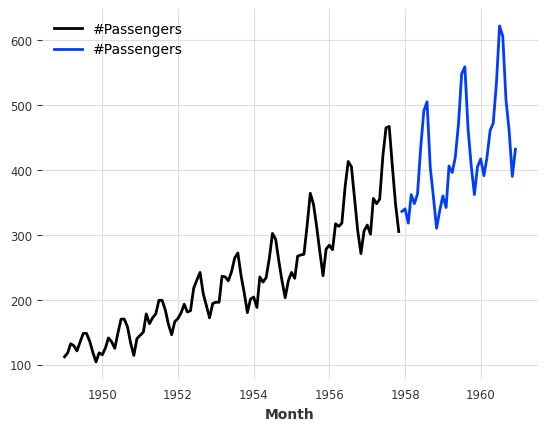

In [3]:
# по процентам
series1, series2 = series.split_before(0.75)
series1.plot()
series2.plot()

<Axes: xlabel='Month'>

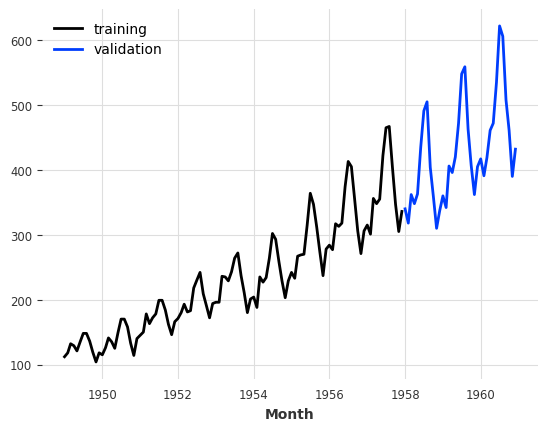

In [4]:
# по дате
train, val = series.split_before(pd.Timestamp("19580101"))
train.plot(label="training")
val.plot(label="validation")

# Простая обработка

<Axes: xlabel='Month'>

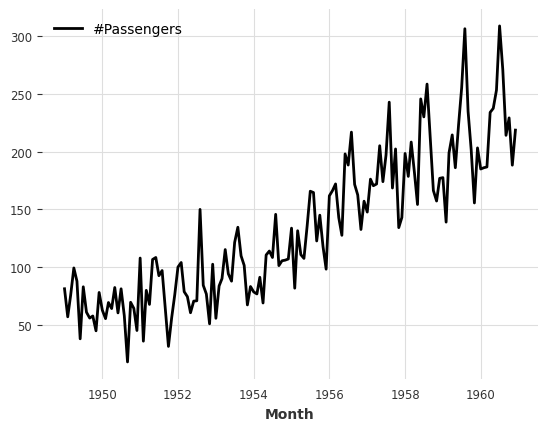

In [5]:
series_noise = TimeSeries.from_times_and_values(
    series.time_index, np.random.randn(len(series))
)
(series / 2 + 20 * series_noise - 10).plot()

<Axes: xlabel='Month'>

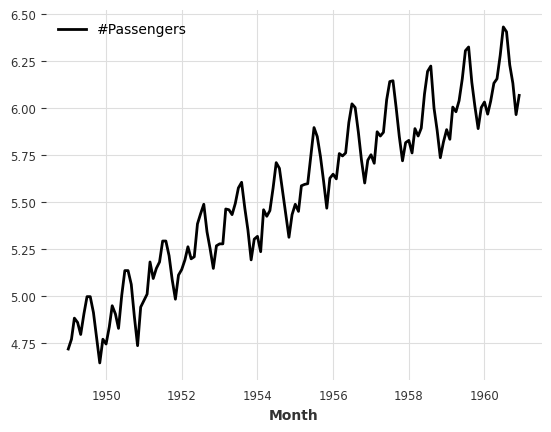

In [6]:
series.map(np.log).plot()

<Axes: xlabel='Month'>

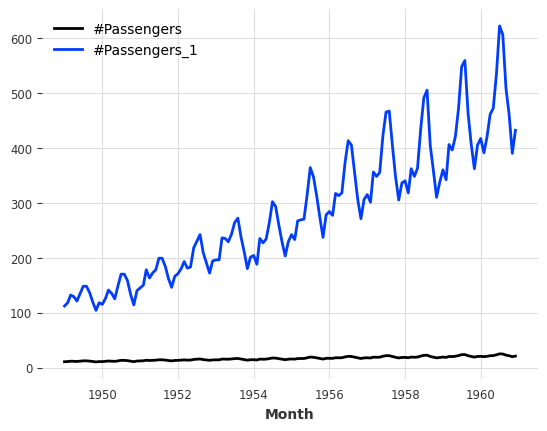

In [7]:
series.map(np.sqrt).stack(series).plot()

<Axes: xlabel='Month'>

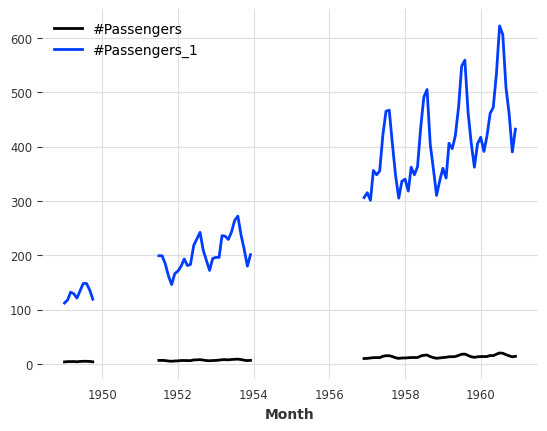

In [28]:
series.map(lambda ts, x: x / ts.days_in_month).stack(series).plot()

<Axes: xlabel='time'>

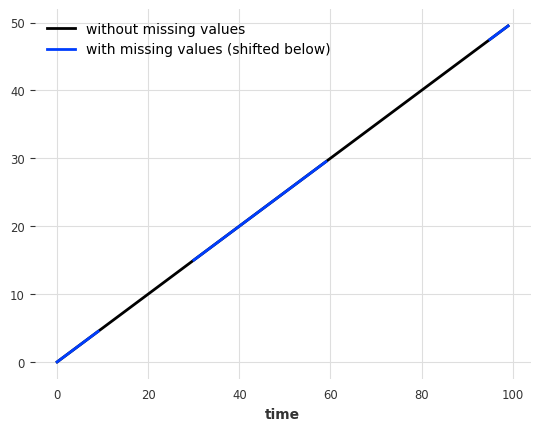

In [9]:
#Восстановление пропущенных значений

from darts.utils.missing_values import fill_missing_values, extract_subseries

values = np.arange(50, step=0.5)
values[10:30] = np.nan
values[60:95] = np.nan
series_ = TimeSeries.from_values(values)


fill_missing_values(series_).plot(label="without missing values")
(series_).plot(label="with missing values (shifted below)")
# extract_subseries(series_, mode="any") # выбирает существующие отрезки

<Axes: xlabel='Month'>

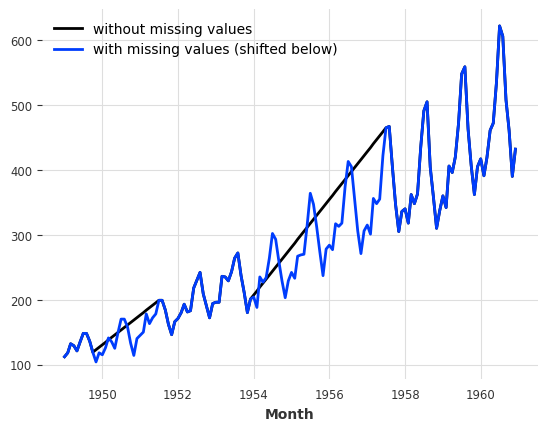

In [35]:
# проверка восстановления более сложного ВР -> восстановление значений линейно между последними значениями
series_ = series.copy()
values_ = series_.all_values(copy=False)
values_[10:30] = np.nan
values_[60:102] = np.nan


fill_missing_values(series_).plot(label="without missing values")
(series).plot(label="with missing values (shifted below)")

# Forecasting 

<Axes: xlabel='Month'>

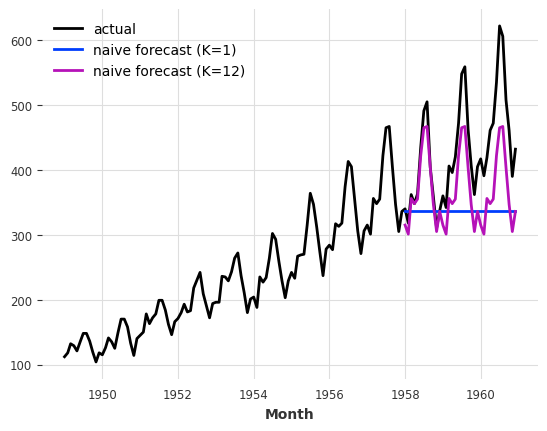

In [10]:
#наивное прогнозирование
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(36)

#подбор помог сильно повысить точность благодаря сильно выраженной сезонности 
naive_model_podbor = NaiveSeasonal(K=12)
naive_model_podbor.fit(train)
naive_forecast_podbor = naive_model_podbor.predict(36)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")
naive_forecast_podbor.plot(label="naive forecast (K=12)")

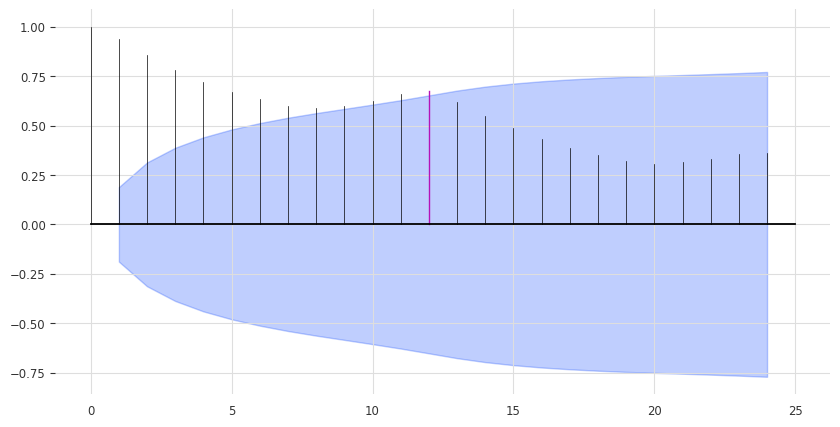

In [11]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=12, alpha=0.05, max_lag=24)

In [12]:
# проверка сезонности
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        train_period = period
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 12.


<Axes: xlabel='Month'>

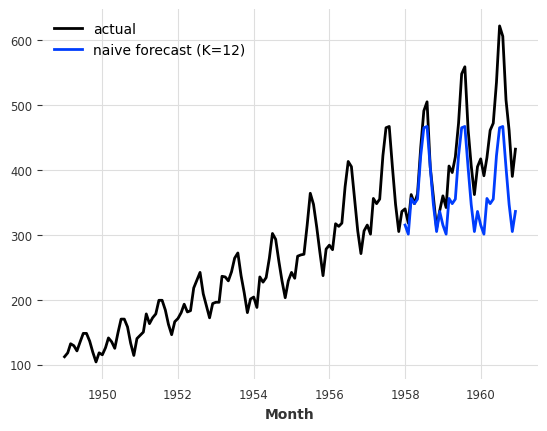

In [13]:
# использование поиска сезонности для автоматической подстановки
seasonal_model = NaiveSeasonal(K=train_period)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(36)

series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=12)")

<Axes: xlabel='Month'>

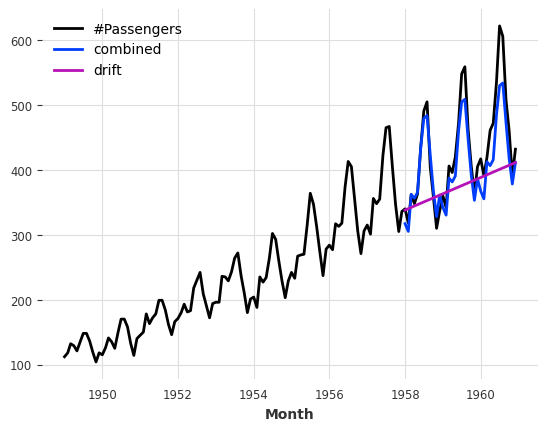

In [14]:
# Добавляем линейный тренд (drift)
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

## Метрики качества

In [15]:
from darts.metrics import mape

print(
    f"Mean absolute percentage error for the combined naive drift + seasonal: {mape(series, combined_forecast):.2f}%."
)

Mean absolute percentage error for the combined naive drift + seasonal: 5.66%.


In [16]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta

def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print(f"model {model} obtains MAPE: {mape(val, forecast):.2f}%")

eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

model ExponentialSmoothing() obtains MAPE: 5.11%


model TBATS() obtains MAPE: 5.87%
model AutoARIMA() obtains MAPE: 11.65%
model Theta() obtains MAPE: 8.15%


# Theta method
Данный метод не рассматривался для экономии времени

# Модели машинного обучения
Пример моделей:
- RegressionModel can wrap around any sklearn-compatible regression model to produce forecasts (it has its own section below).
- RNNModel is a flexible RNN implementation, which can be used like DeepAR.
- NBEATSModel implements the N-BEATS model.
- TFTModel implements the Temporal Fusion Transformer model.
- TCNModel implements temporal convolutional networks.
- …

<Axes: xlabel='Month'>

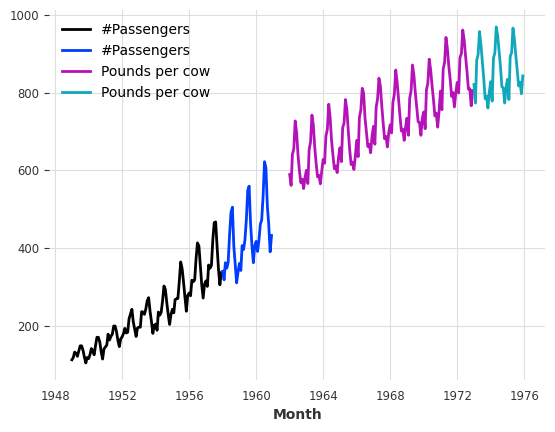

In [17]:
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset

series_air = AirPassengersDataset().load().astype(np.float32)
series_milk = MonthlyMilkDataset().load().astype(np.float32)

# set aside last 36 months of each series as validation set:
train_air, val_air = series_air[:-36], series_air[-36:]
train_milk, val_milk = series_milk[:-36], series_milk[-36:]

train_air.plot()
val_air.plot()
train_milk.plot()
val_milk.plot()

<Axes: xlabel='Month'>

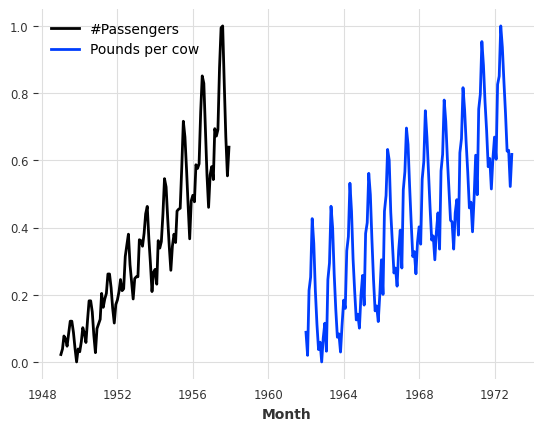

In [21]:
# масштабирование
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
train_air_scaled, train_milk_scaled = scaler.fit_transform([train_air, train_milk])

train_air_scaled.plot()
train_milk_scaled.plot()

## Пример: N-BEATS

Нужные параметры для настройки
- `input_chunk_length`: this is the “lookback window” of the model - i.e., how many time steps of history the neural network takes as input to produce its output in a forward pass.

- `output_chunk_length`: this is the “forward window” of the model - i.e., how many time steps of future values the neural network outputs in a forward pass.

In [22]:
from darts.models import NBEATSModel

model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

model.fit([train_air_scaled, train_milk_scaled], epochs=50, verbose=True);

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

<Axes: xlabel='Month'>

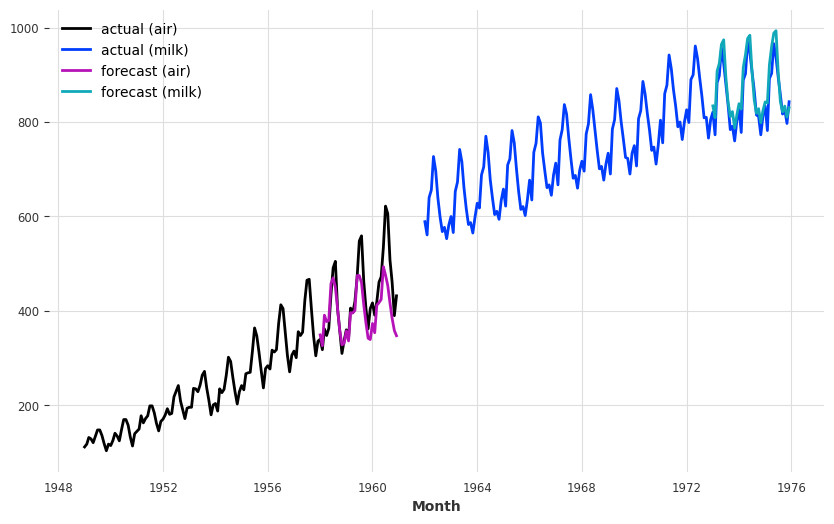

In [23]:
pred_air, pred_milk = model.predict(series=[train_air_scaled, train_milk_scaled], n=36)

# scale back:
pred_air, pred_milk = scaler.inverse_transform([pred_air, pred_milk])

plt.figure(figsize=(10, 6))
series_air.plot(label="actual (air)")
series_milk.plot(label="actual (milk)")
pred_air.plot(label="forecast (air)")
pred_milk.plot(label="forecast (milk)")